In [ ]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
import hdbscan
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

# Load in the LAMOST DR7-Gaia-Planet catalogue

In [2]:
# LOAD THE APOGEE DATA
path = '/Users/qpasa/Desktop/Master/data/lamost_planets_gaia.fits'
tb = fits.open(path)
data = tb[1].data 

In [18]:
mask_ges_planet = (data['feh']<-0.8)&(data['ruwe']<1.4)&(data['parallax_over_error']>20)&(data['teff']>3500)&(data['teff']<6000)\
        &(data['logg']<4.2)&(data['logg']>0)
print(len(data[mask_ges_planet]))
print((data['feh'][mask_ges_planet]))
print((data['alpha_m'][mask_ges_planet]))


2
[-0.808 -1.316]
[0.142718 0.278302]


(-0.5, 0.7)

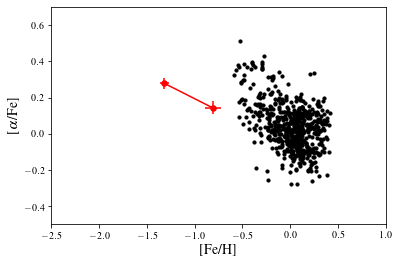

In [4]:
# check the alpha-Fe plane

plt.scatter(data['feh'],data['alpha_m'],s=10,c='k')
plt.scatter(data['feh'][mask_ges_planet],data['alpha_m'][mask_ges_planet],s=30,c='r')
plt.errorbar(data['feh'][mask_ges_planet],data['alpha_m'][mask_ges_planet],xerr= data['feh_err'][mask_ges_planet],yerr= data['alpha_m_err'][mask_ges_planet],color='r')
plt.xlabel(r'[Fe/H]', fontsize=14)
plt.ylabel(r'[$\alpha$/Fe]', fontsize=14)
plt.xlim(-2.5,1)
plt.ylim(-0.5,0.7)


# Let's compute the orbits of this GES-like star

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import galpy
from galpy.util import bovy_coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.bovy_conversion import get_physical

(array([314., 333., 175.,  42.,  11.,   3.,   2.,   0.,   1.,   4.]),
 array([  29.4906216 ,  431.53758044,  833.58453928, 1235.63149812,
        1637.67845696, 2039.7254158 , 2441.77237464, 2843.81933348,
        3245.86629232, 3647.91325116, 4049.96021   ]),
 <a list of 10 Patch objects>)

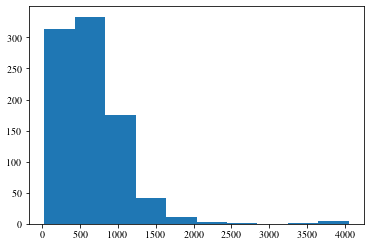

In [7]:
plt.hist(data['rgeo'])

In [8]:
ro = 8.178
vo = 220.
zo = 0.025

ra, dec= data['ra'], data['dec']
lb= bovy_coords.radec_to_lb(ra,dec,degree=True, epoch=None)
pmra, pmdec= data['pmra'], data['pmdec']
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= data['rgeo']/1e3, data['rv']
rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
vsolar= np.array([-11.1,12.6,7.25])
vsun= np.array([0.,1.,0.,])+vsolar/vo
X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
XYZ = np.dstack([X, Y, Z])[0]
vxyz = np.dstack([vx,vy,vz])[0]
Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                vsun=vsun,
                                                                Xsun=1.,
                                                                Zsun=zo/ro,
                                                                galcen=True)

In [9]:
def E(dat,
              return_rphiz =True,
              verbose =False,
              ro = 8.,
              vo = 220.,
              zo = 0.025,
              keys = ['ra', 'dec', 'rgeo', 'pmra', 'pmdec', 'rv'],
              #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
              parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    #vxvv = np.dstack((keys[:,0],keys[:,1],keys[:,2]/1e3,keys[:,3],keys[:,4],keys[:,5]))
    print(np.shape(vxvv))
    mp=McMillan17
    E = np.zeros(len(vxvv))
    print('running E')
    for idx, i in tqdm.tqdm(enumerate(vxvv)):
      #o = Orbit(vxvv=[p for p in j],radec=True,**get_physical(McMillan17))
        o = Orbit(vxvv=[vxvv[idx,0],vxvv[idx,1],(vxvv[idx,2]/1e3),vxvv[idx,3],vxvv[idx,4],vxvv[idx,5]],radec=True, **get_physical(McMillan17)) #here you create an iterable which iterates over the sampled_vxvv values.
        E[idx] = o.E(analytic=True,pot=McMillan17)
    return E


In [10]:
energies = E(data)

12it [00:00, 119.28it/s]

(885, 6)
running E


885it [00:05, 154.25it/s]


In [11]:
print(energies[mask_ges_planet])

[-151338.30869064 -155767.16574022]


(-500, 500)

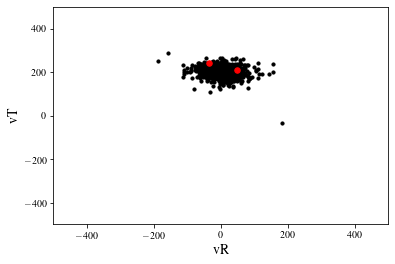

In [12]:
plt.scatter(vRvTvz[:,0]*220,vRvTvz[:,1]*220,s=10,c='k')
plt.scatter(vRvTvz[:,0][mask_ges_planet]*220,vRvTvz[:,1][mask_ges_planet]*220,s=30,c='r')
plt.xlabel(r'vR', fontsize=14)
plt.ylabel(r'vT', fontsize=14)
plt.xlim(-500,500)
plt.ylim(-500,500)


In [14]:
from galpy.actionAngle import UnboundError

# fast_orbitparams = np.zeros((len(ra),4))
# actions = np.zeros((len(ra),3))
mp=McMillan17
delta = estimateDeltaStaeckel(mp, Rpz[:,0], XYZ[:,2], no_median=True)
aAS = actionAngleStaeckel(pot=mp, delta=delta)
e0, Zmax0, rperi0, rap0 = aAS.EccZmaxRperiRap(Rpz[:,0], vRvTvz[:,0], vRvTvz[:,1], XYZ[:,2], vRvTvz[:,2], Rpz[:,1], delta=delta)


In [22]:
lz = np.array(Rpz[:,0]*vRvTvz[:,1])
lz2 = lz*220*8.178
print(lz2[mask_ges_planet])
print(e0[mask_ges_planet])


[1947.30196402 1721.0222918 ]
[0.15546341 0.16976301]


(-300000, 0)

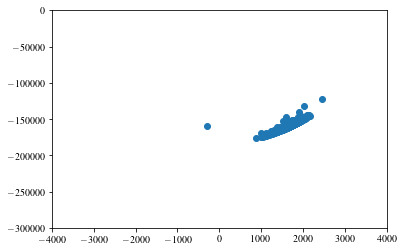

In [16]:
plt.scatter(lz2, energies)
plt.xlim(-4000,4000)
plt.ylim(-300000,0)


In [25]:
print(data['feh'][lz2<0])
print(energies[lz2<0])
print(e0[lz2<0])
print(data['alpha_m'][lz2<0])
print((data['source_id'][lz2<0]))
print((data['pl_name'][lz2<0]))

[-0.702]
[-160006.64774168]
[0.89787604]
[-9999.]
[625137162857354880]
['BD+20 2457 b']
